## Making a Mask of Science Target Spaxels for IFU Science
-------

Created by Dr. Taylor Hutchison, NASA GSFC,  
on behalf of the TEMPLATES team.

The science target pixel mask making is an important step, as it enables you to have both 

1. a 2D mask of which spaxels likely belong to the science target 
2. a map of the science target in bins of signal-to-noise (S/N), which are turned into individual 2D mask layers  

Both the general mask and the binned S/N maps will be used in the layered sigma clipping part of the algorithm, so it's important to be careful and detailed in this step to ensure that the layered sigma clipping routine works as well as it can.  This part of the algorithm is described in H+, section 2.1.

In [1]:
from routines import * # helper functions & the needed imports

### First things first

We're going to start by reading in the straight-from-the-pipeline cube.

In [2]:
# --------------------------
# SCIENCE TARGET INFORMATION
# --------------------------
target = 'SGAS1723' # science target name

# returns dictionary of info for chosen science target
# also path to reduced FITS cubes to read in
science_target, path, grating = get_target_info(target)

# target-specific information & data read-in
filename = science_target['grating'][grating]['filename']
data,header = fits.getdata(path+filename,header=True)
error = fits.getdata(path+filename,ext=2)

data.shape # just to double-check it's a 3D cube

(3915, 51, 53)

--------

## Part 1: Making the overall science target mask using an emission line

*Defining the central slice for the brightest emission line in the cube:*

For our example galaxy, the brightest line is [OIII]5008.  Using DS9 software, I chose 854 to be the central slice.  Also confirm the extent of the emission feature by clicking through slices above and below the chosen central slice.

In [3]:
central_slice = 837 # roughly center of [OIII] emission line
lower_end = 5 # slices from center
upper_end = 5 # slices from center

# setting up the slice indexes
start = central_slice - lower_end
end = central_slice + upper_end + 1 # for indexing, have to add 1

Making a S/N map of our chosen emission line by summing the slices in the data cube and summing the error cube in quadrature.

In [4]:
# signal
line = np.nansum(data[start:end],axis=0)

# error
err = [s**2 for s in error[start:end]]
line_err = np.sqrt(np.nansum(err,axis=0))


# making the S/N map!
snr_map = line / line_err

/var/folders/bd/fxffskzs3rvczrn0b8m7jpn46n113h/T/ipykernel_87301/336631520.py:10: RuntimeWarning: invalid value encountered in divide
  snr_map = line / line_err


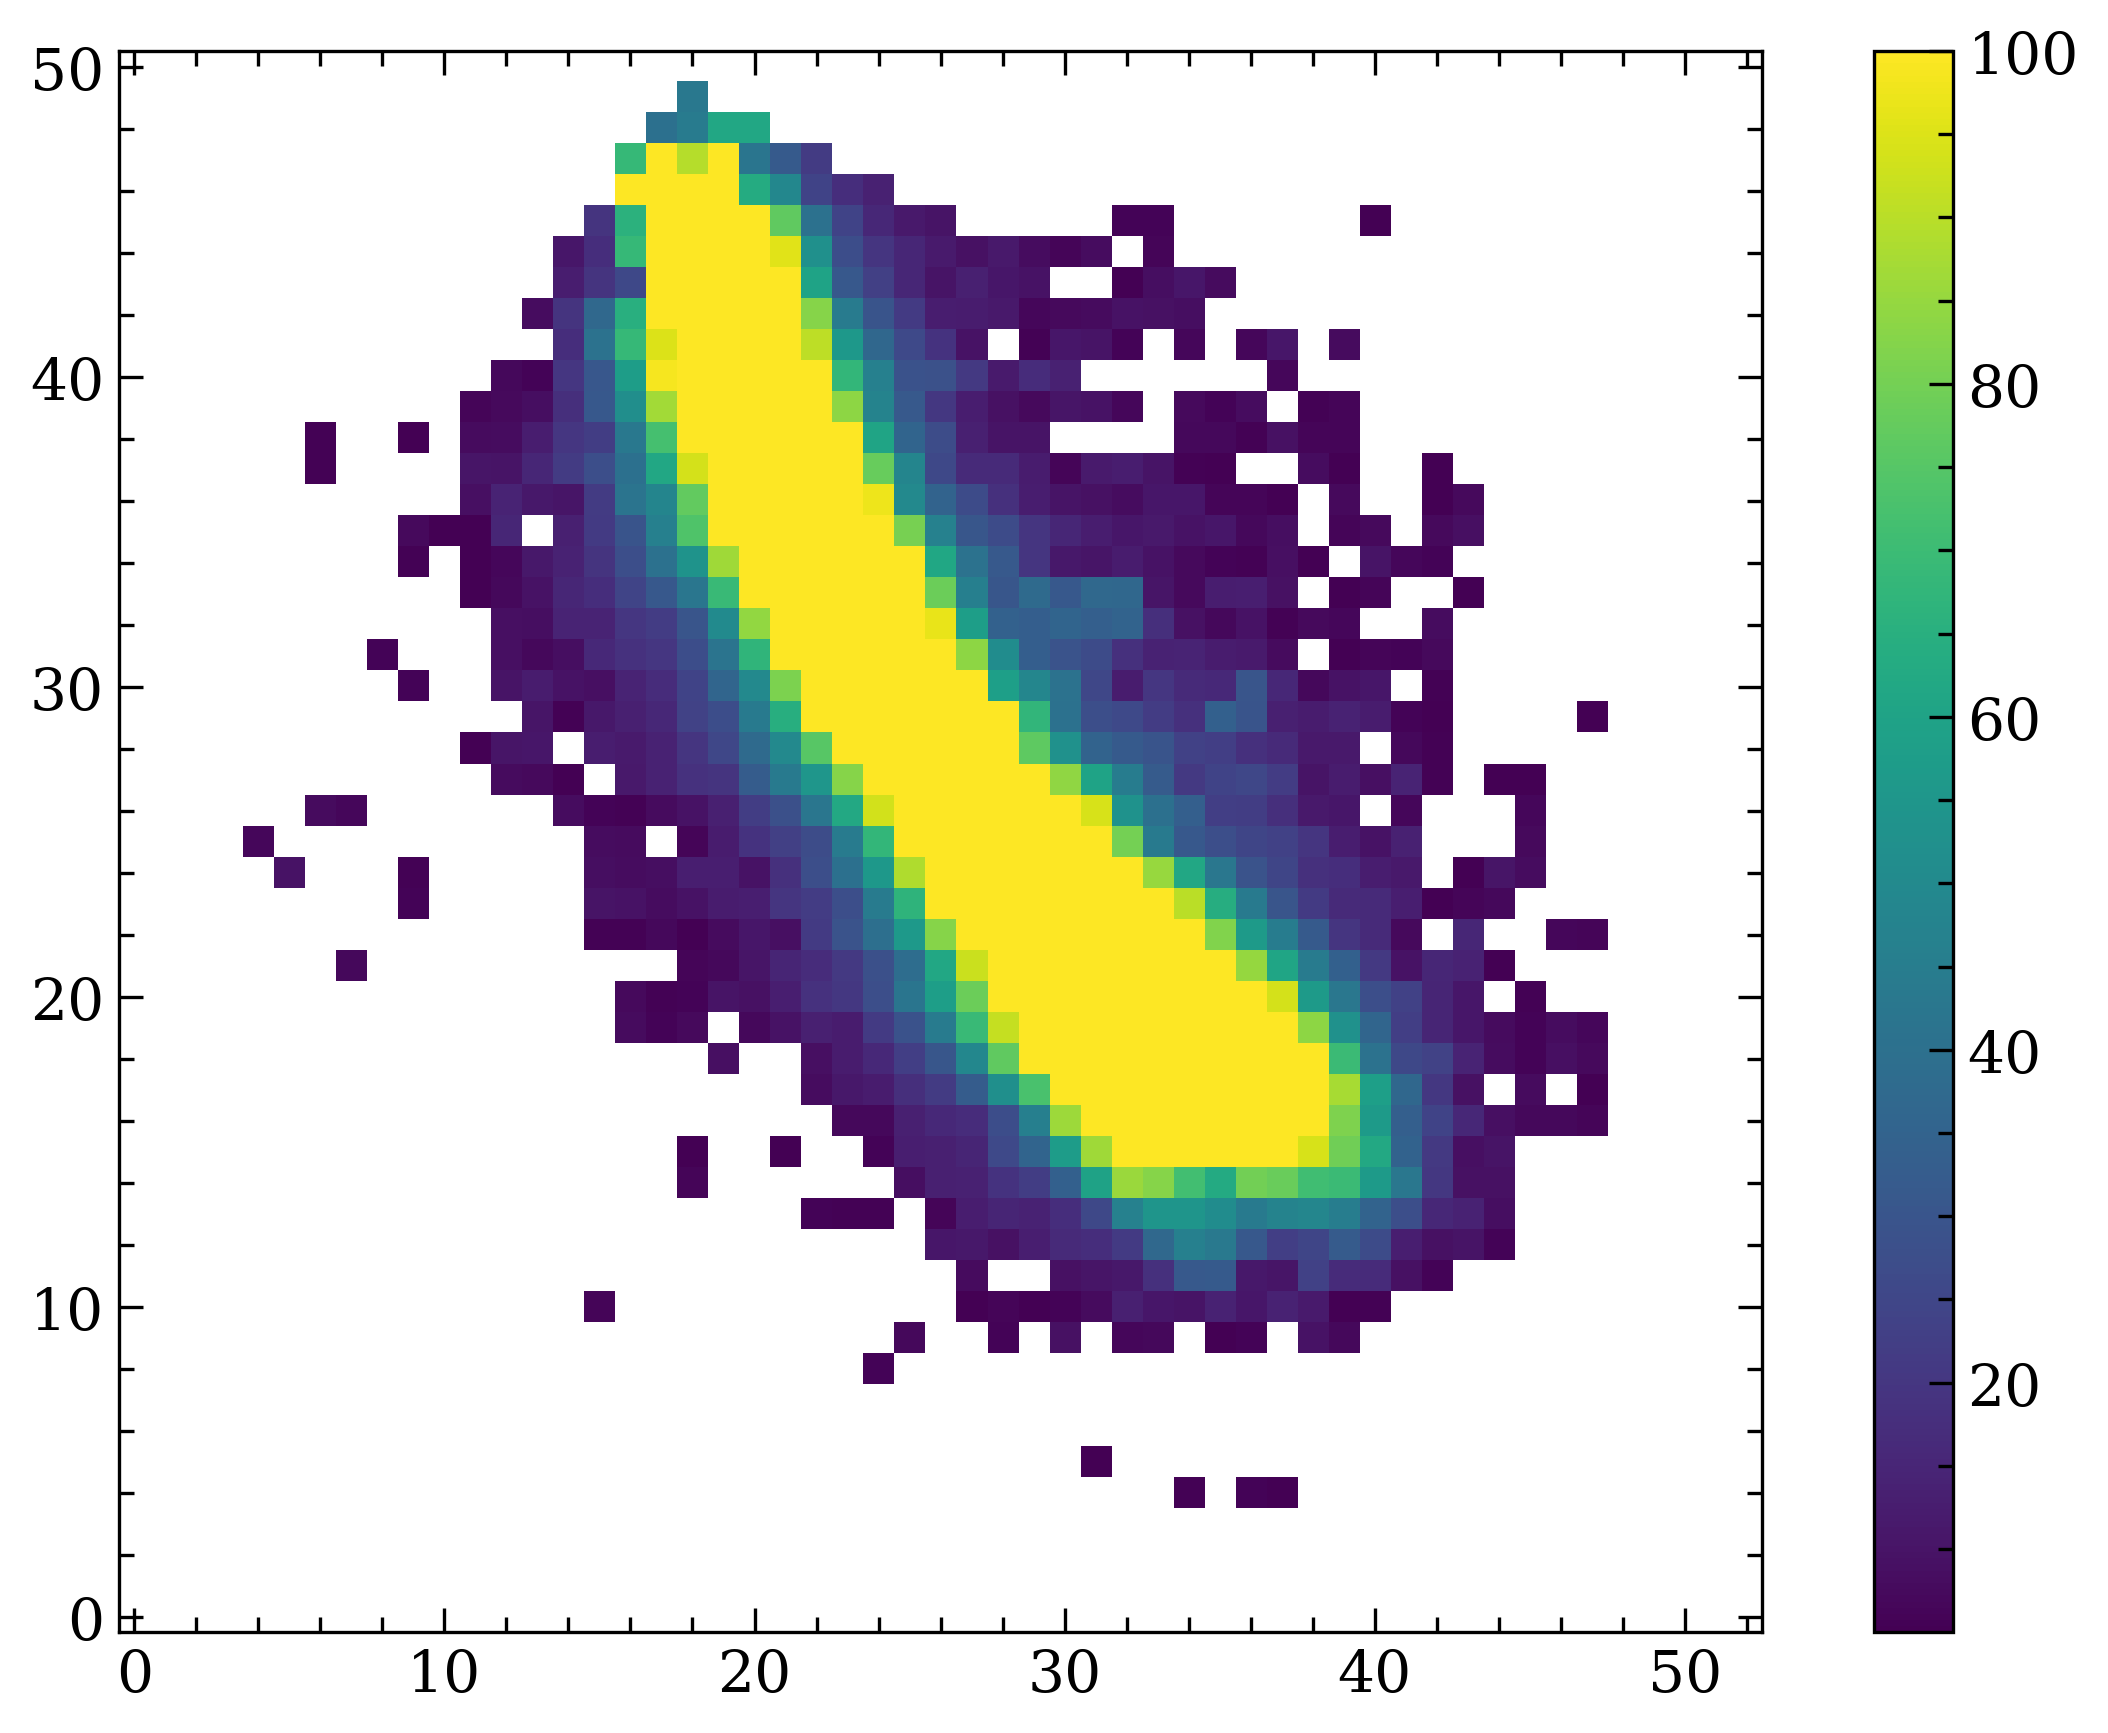

In [5]:
plt.figure(figsize=(8,6))

# setting the colorbar ranges -- can change these to see how plot changes
minsnr = 5
maxsnr = 100

# hiding spaxels with S/N < minsnr
snr_map[snr_map < minsnr] = np.nan
    
im = plt.imshow(snr_map,origin='lower',cmap='viridis',clim=(minsnr,maxsnr))
plt.colorbar(im)
    
plt.tight_layout()
plt.show()
plt.close('all')

### Great!  First pass in making the galaxy mask is done!

By defining a min S/N, we've removed most of the spaxels that aren't associated with the galaxy (as we've specifically centered on an emission line, so there should be SOME amount of S/N for galaxy spaxels).  Next, we need to mask out additional spaxels that are likely noise or artifacts leftover from the pipeline.

### Masking out pixels

This section will use code from my pixel-patches GitHub repository ([link](https://github.com/aibhleog/patches-pixels)), which has a function that allows us to use patches on our plots to help pick out pixels to mask.  Below shows how it works.

In [6]:

def get_points(mypatch,size):
    '''
    INPUTS:
    >> mypatch ---- the matplotlib patch shape
    >> size ------- integer, the size in pixels of one 
                    side of the "galaxy" image
                    
    OUTPUTS:
    >> points ----- the list of valid x,y coordinates
                    that overlap with the patch
    '''
    # create a list of possible coordinates
    x,y = np.arange(0,size),np.arange(0,size)

    g = np.meshgrid(x,y)
    coords = list(zip(*(c.flat for c in g)))

    # create the list of valid coordinates (from patch)
    points = np.vstack([p for p in coords if mypatch.contains_point(p, radius=0)])
    return np.array(points)


In [7]:
# making a convenience script that will help us add as many patches as we want in masking

def add_mask_patch(patch, axes, snr_mask):

    # getting associated pixels for patch
    points = get_points(patch,len(snr_mask))
    
    # setting these pixels to NaNs
    snr_mask[points[:,1],points[:,0]] = np.nan
    
    # plot points on each subplot
    for ax in axes:
        ax.scatter(points[:,0],points[:,1],color='k',s=10,alpha=0.8,zorder=10)


#### Plotting our S/N map and trying out masking pixels.

<div class="alert alert-success">
    <b>NOTE</b> -- this example shows only one patch being used, but in practice I generally add more.
</div>

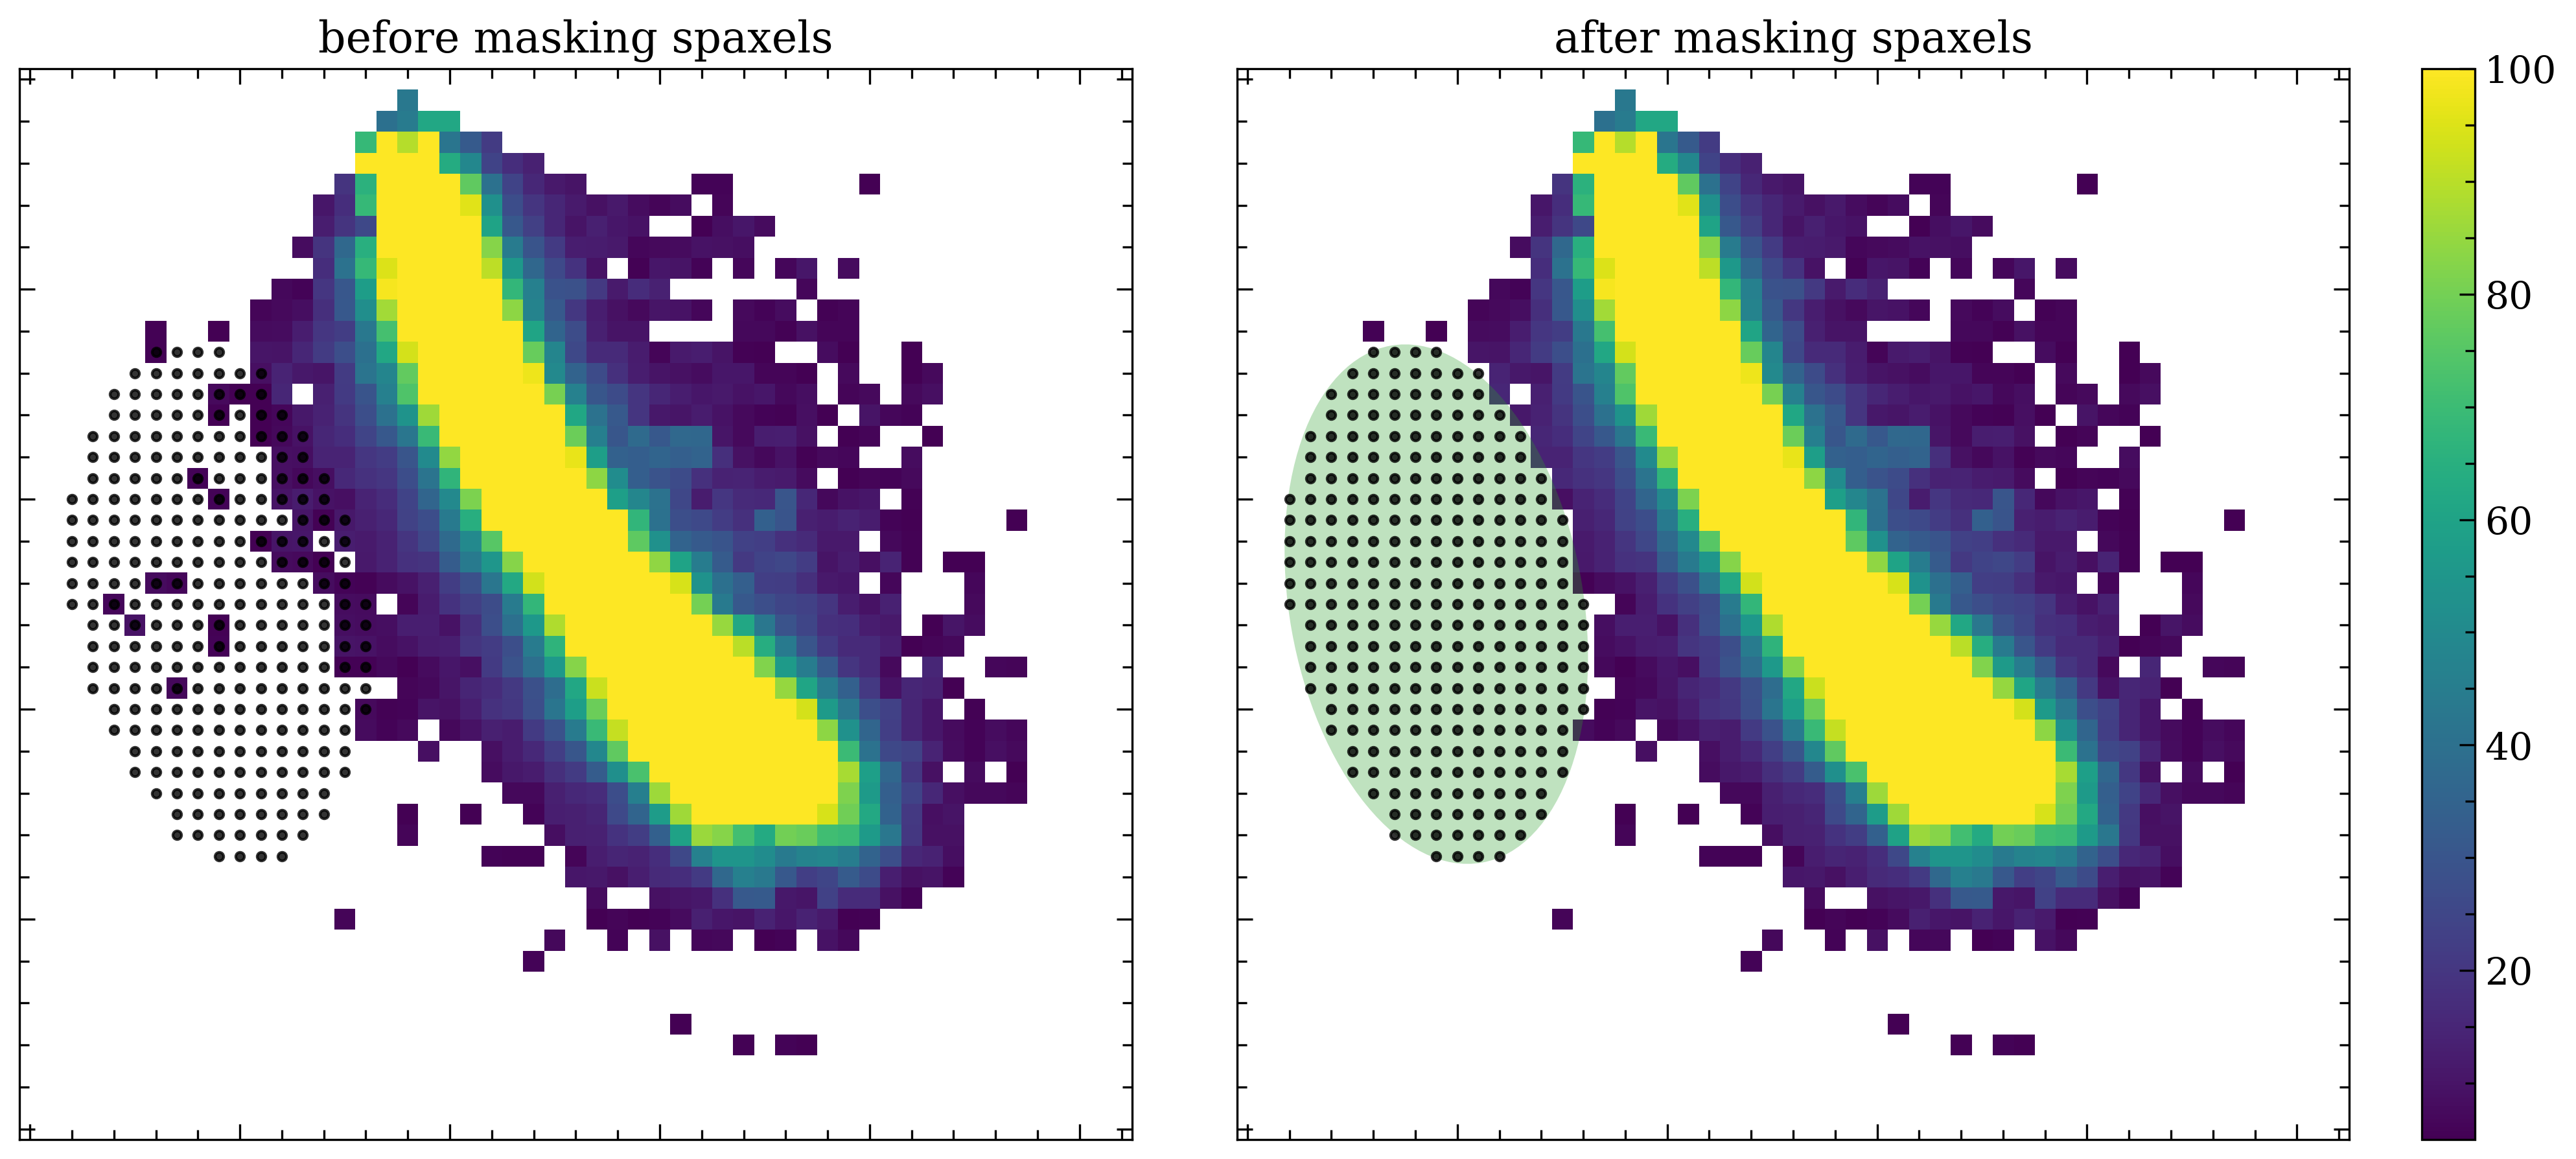

In [8]:
# making a copy of snr_map to use in masking
# ---------------------------
snr_cut = snr_map.copy()



# looking at S/N map
# -------------------
plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1.25])

ax1 = plt.subplot(gs[0]) # before masking
ax2 = plt.subplot(gs[1]) # after masking


# PLOT 1
ax1.set_title('before masking spaxels',fontsize=16)
ax1.imshow(snr_map,origin='lower',cmap='viridis',clim=(minsnr,maxsnr),zorder=0)




# --------------------
# MASKING with patches
# --------------------

# the patch shape we'll be using;
# you can change these values to see how it changes what's masked
# ALSO feel free to copy paste this to make more patches

ellipse1 = Ellipse((9,25),
                  width = 14,
                  height = 25,
                  angle = 10,
                  alpha = 0.3,
                  facecolor = 'C2')

# running our convenience function on patch(es)
add_mask_patch(ellipse1, [ax1,ax2], snr_cut)




# PLOT 2
ax2.set_title('after masking spaxels',fontsize=16)
im = ax2.imshow(snr_cut,origin='lower',cmap='viridis',clim=(minsnr,maxsnr),zorder=0)
cbar = plt.colorbar(im)



# adding patch to second subplot
# ------------------------------
ax2.add_patch(ellipse1) # make sure patch is added to plot last


# general formatting
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])


plt.tight_layout()
plt.show()
plt.close('all')

### Making the new map

We do this by setting all non-NaN spaxels to 1, and the rest will be 0.

In [9]:
# making the new map
new_map = np.zeros(snr_cut.shape) # making a 2D array of all zeros
new_map[snr_cut>0] = 1 # everything not NaNs

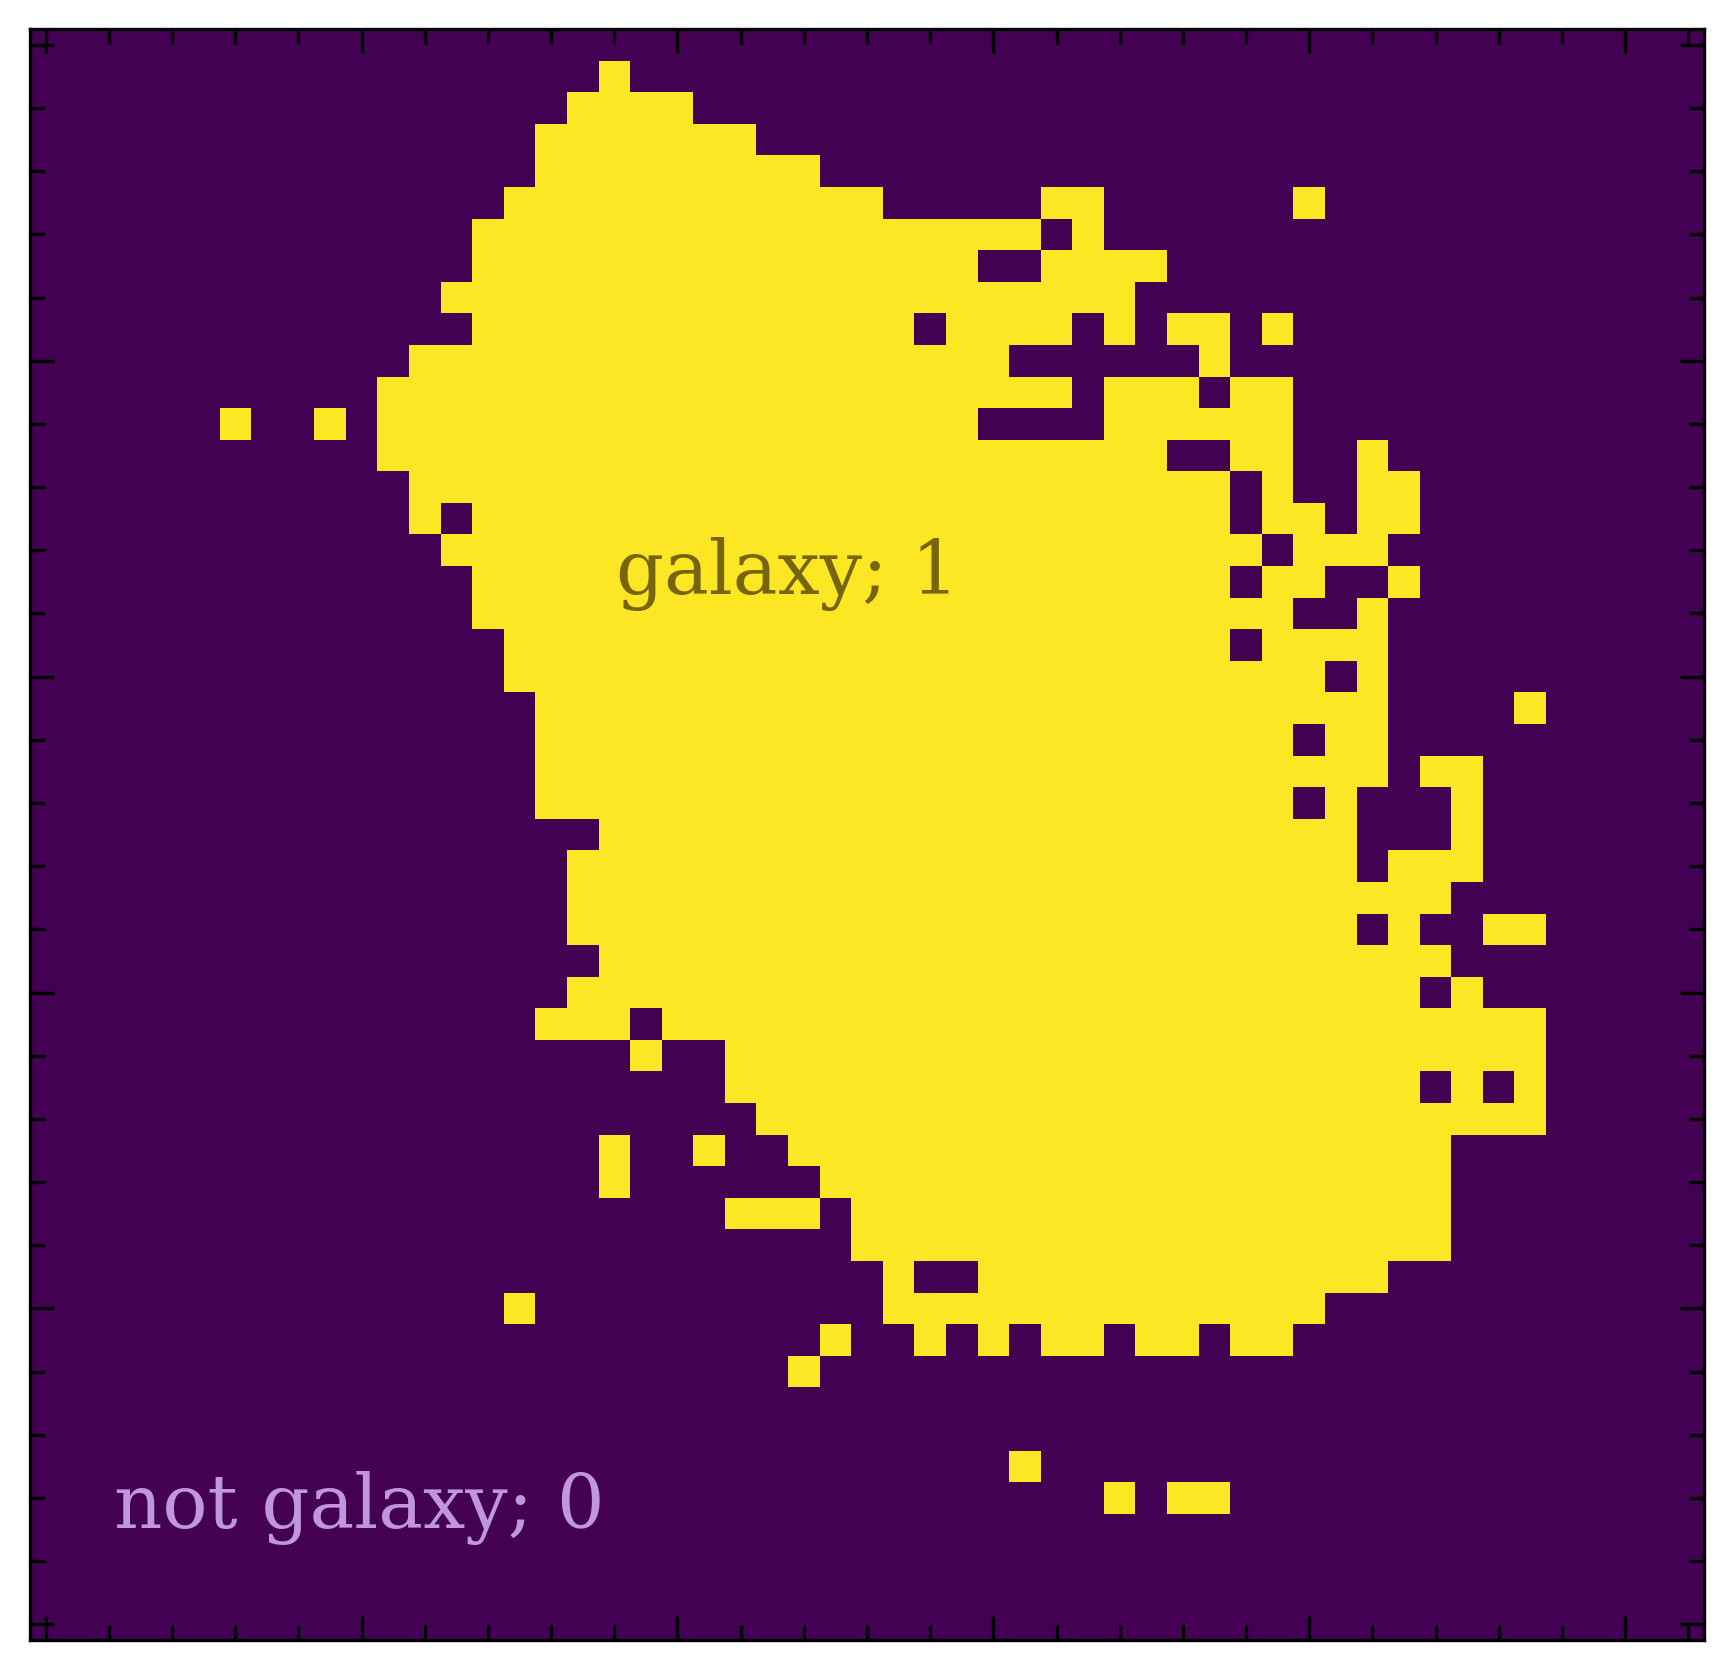

In [10]:
# saving manual map
plt.figure(figsize=(6,6))

plt.imshow(new_map,origin='lower',cmap='viridis')

plt.text(0.05,0.07,'not galaxy; 0',color='#C096E1',transform=plt.gca().transAxes,fontsize=18)
plt.text(0.35,0.65,'galaxy; 1',color='#77650D',transform=plt.gca().transAxes,fontsize=18)

plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.tight_layout()
plt.show()

plt.close('all')

#### Sometimes you may need to add or remove a spaxel from the mask

This is because we're working with the straight-from-the-pipeline cubes, so there will be some artifacts or bad pixels that may mess up the S/N for a particular spaxel.  To fix this, uncomment the following code cell and then change the `y` and `x` in the brakets into numbers and rerun the plotting cell above until you're centered on the pixel you want to change.  Then, change the `np.nan` to a `1` or `0` -- depending upon if you wanted to include or remove the pixel from the mask.

Copy-paste this line of code to change more pixels as needed.

In [11]:
# new_map[y,x] = np.nan

----------

## Part II: Making S/N bins from our galaxy mask 

This step is also very important.  Essentially, once we're satisfied with the overall galaxy mask we've made above, now we take that map and plot the S/N values as contours, to determine how many bins to make.  We'll use these S/N bins in our sigma clipping routine in the next notebook, so take some time getting this how you want it.

In [12]:
# first we need to use our final galaxy mask to remake our S/N map 
# (just in case we added or removed pixels in the preivous step)

snr_cut = snr_map.copy() # doing this again to start fresh
snr_cut[new_map < 1] = np.nan # masking out all not-galaxy spaxels

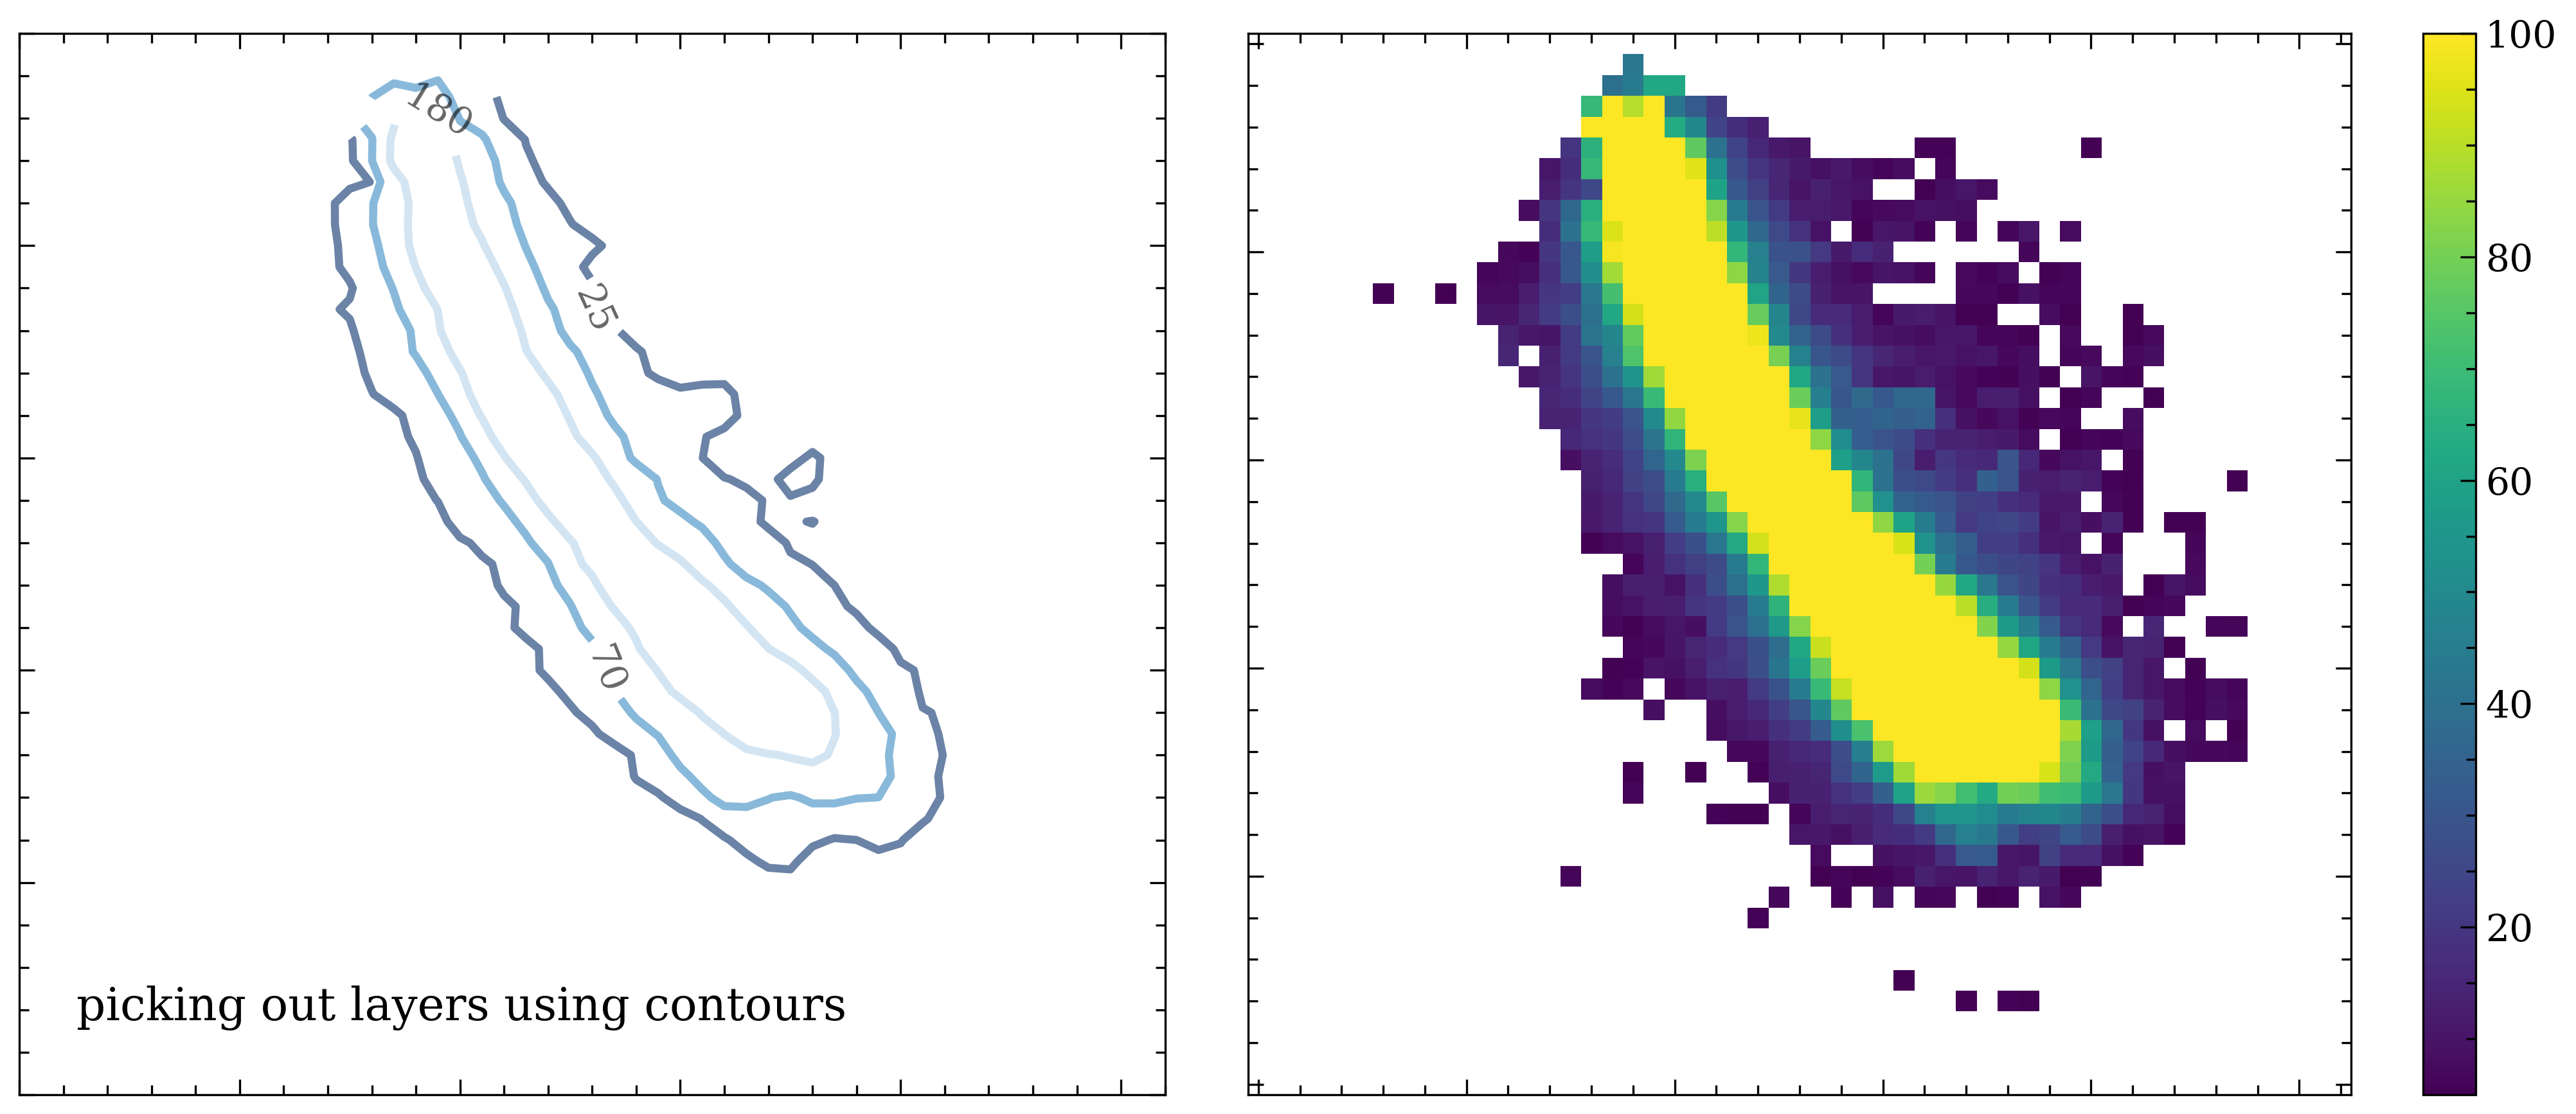

In [13]:
# looking at S/N map
plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1.25])

ax1 = plt.subplot(gs[0]) # S/N map
ax2 = plt.subplot(gs[1]) # S/N contours



# PLOT 1
im = ax2.imshow(snr_cut,origin='lower',cmap='viridis',clim=(minsnr,maxsnr))
cbar = plt.colorbar(im)



# making list of spaxel coordinates based on data shape
# to use in contouring
x0,y0 = np.arange(0,snr_cut.shape[1]),np.arange(0,snr_cut.shape[0])
g = np.meshgrid(x0,y0)



# using contours to choose layers
# -------------------------------
# change these values as needed to get the contours you want!
levels = np.array([25,70,180])


    
# making array colors
cmap = plt.get_cmap('Blues_r')
colors = [cmap(j) for j in np.linspace(0,0.7,len(levels))]


# PLOT 2
contours = ax1.contour(g[0], g[1], snr_cut, levels, origin='upper',alpha=0.6,linewidths=3,colors=colors)
plt.clabel(contours, inline=True, fontsize=14,colors='k')

ax1.text(0.05,0.07,'picking out layers using contours',
         transform=ax1.transAxes,fontsize=17)



ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])


plt.tight_layout()
plt.show()
plt.close('all')

### Let's look at those layers indiviudally

In [14]:
# setting up full S/N bins (including min and max values)
levels = np.concatenate(([minsnr],levels,[round(np.nanmax(snr_cut)+10)]))

# looking at bins
levels

array([  5,  25,  70, 180, 684])

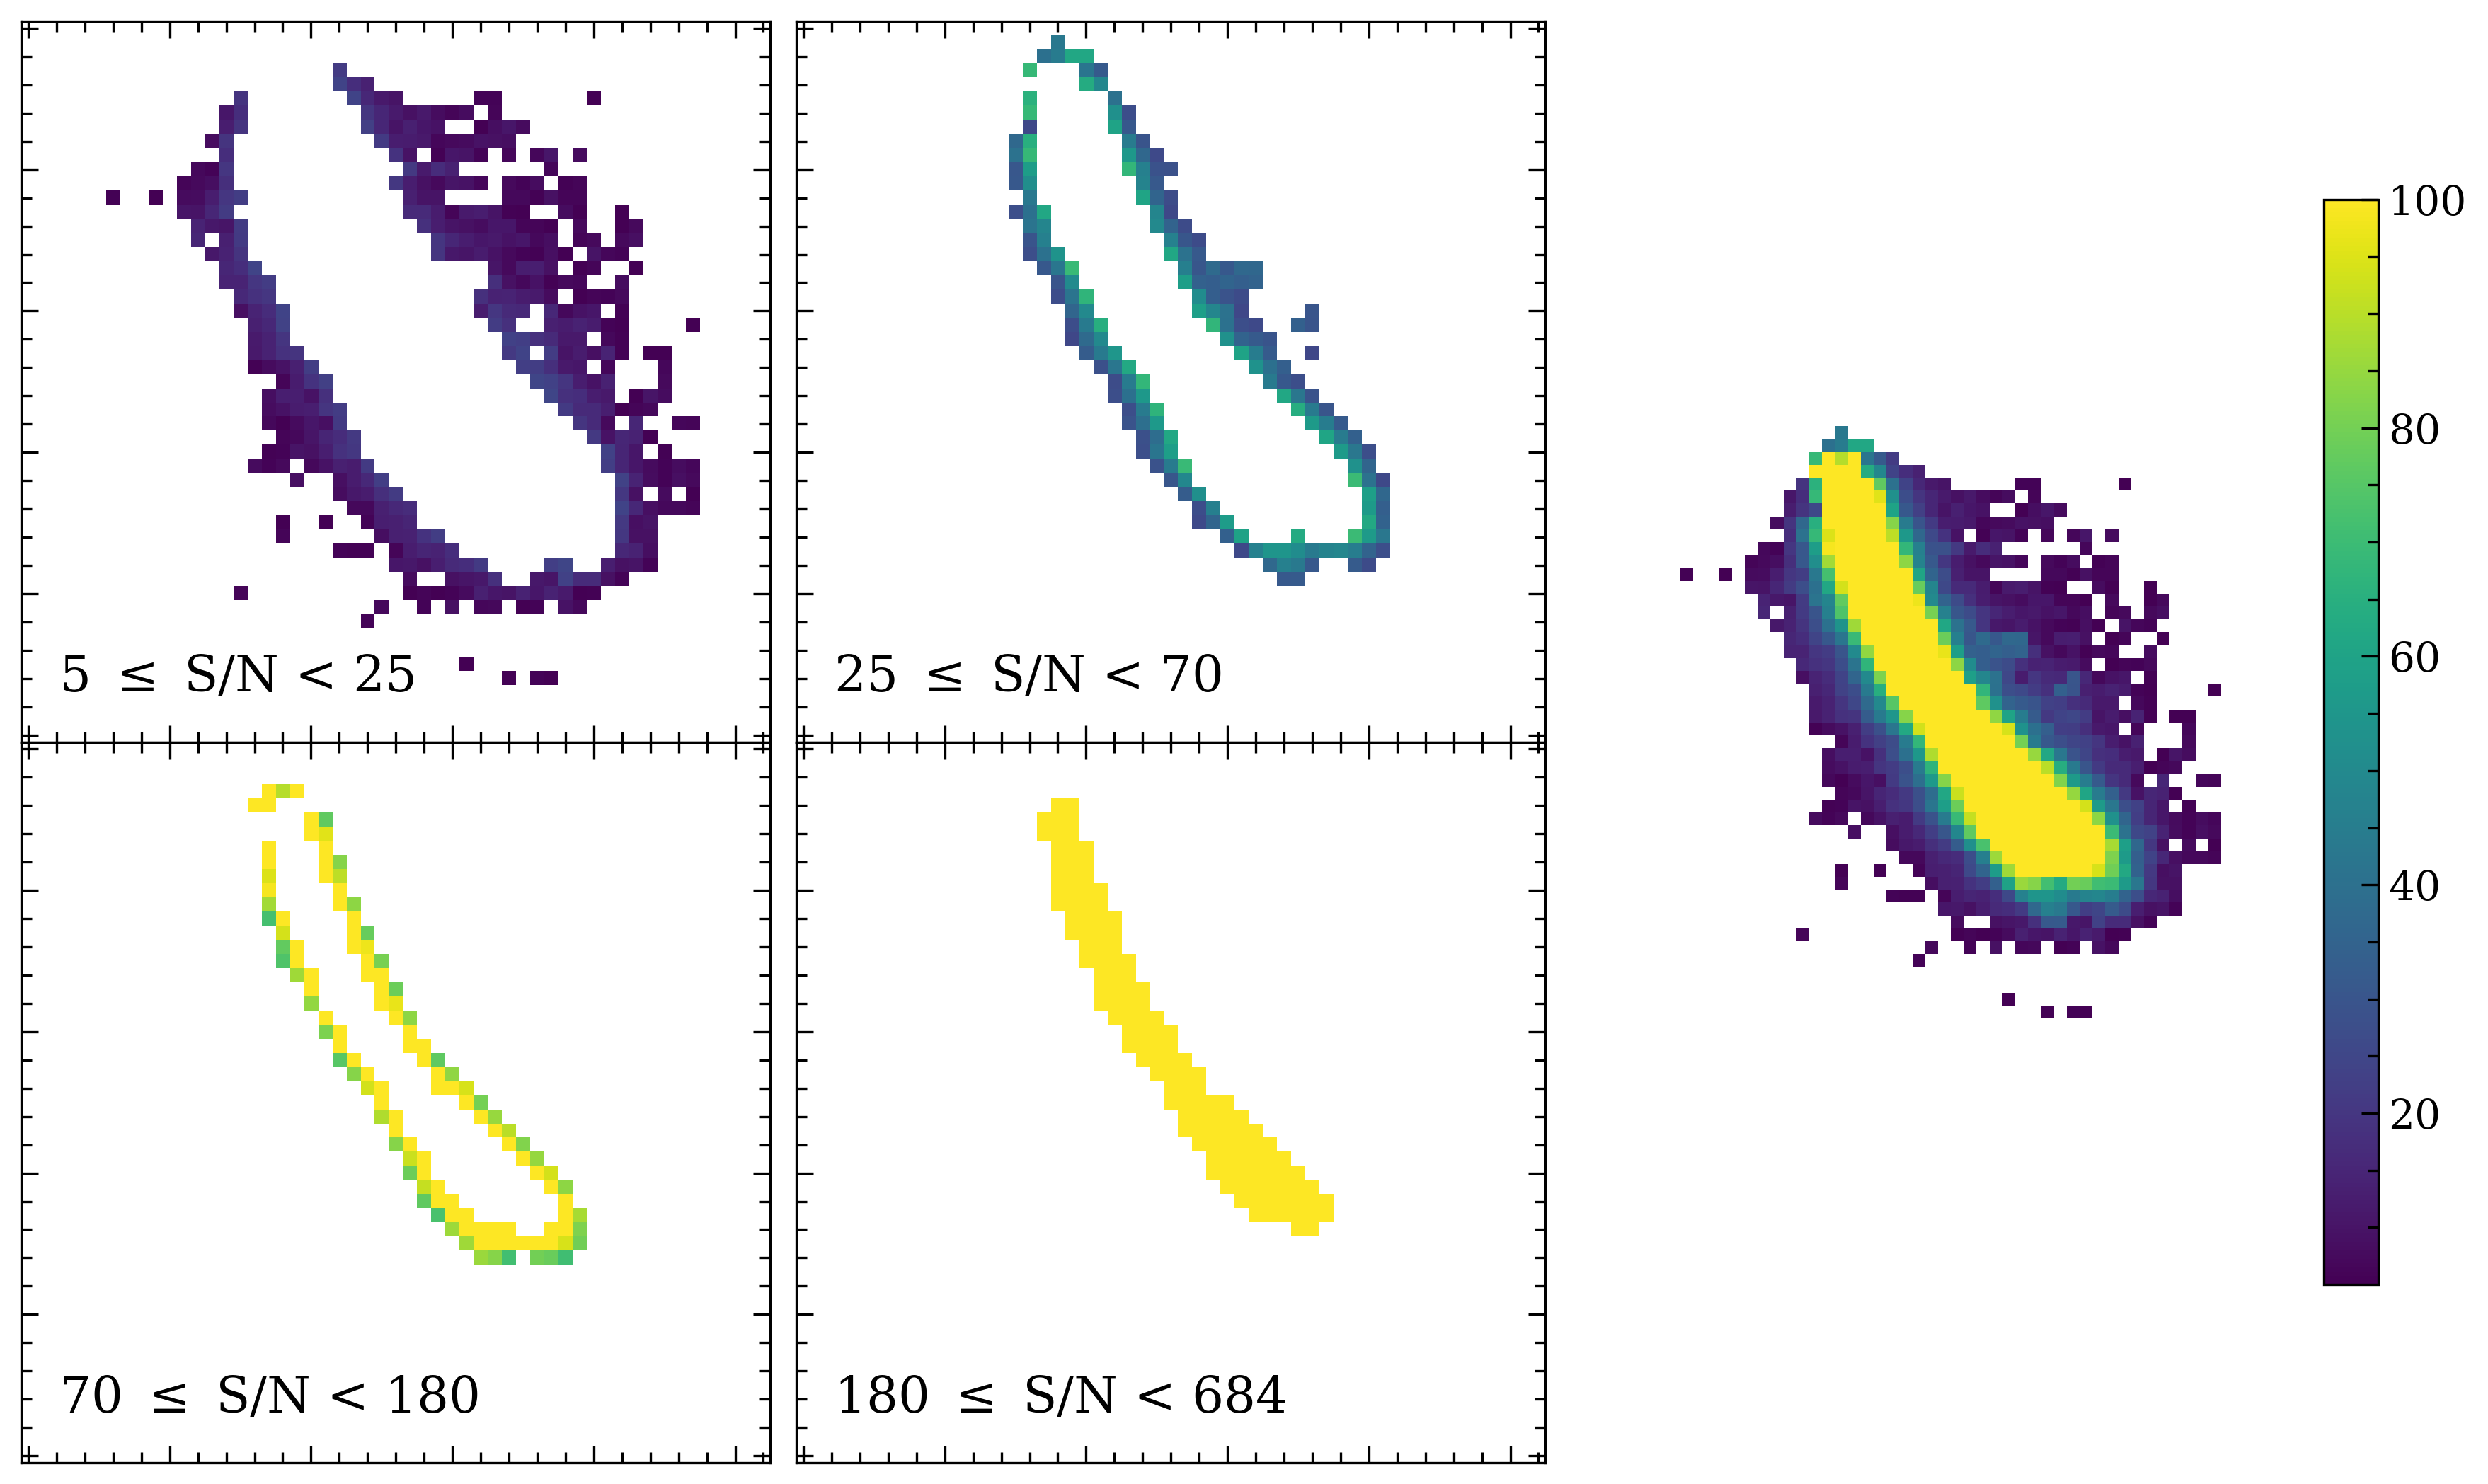

In [15]:
plt.figure(figsize=(12,7.21))
gs0 = gridspec.GridSpec(1,2,width_ratios=[2,1])


# PLOT 1
ax = plt.subplot(gs0[1])
ax.axis('off')

ax.imshow(snr_cut,origin='lower',cmap='viridis',clim=(minsnr,maxsnr))
cbar = plt.colorbar(im,ax=ax,fraction=0.07)

ax.set_yticklabels([])
ax.set_xticklabels([])



# LOOKING AT LEVELS
gs = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=gs0[0],
                    width_ratios=[1,1],height_ratios=[1,1],
                    wspace=0,hspace=0)

# assumes 4 S/N bins
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
axes = [ax1,ax2,ax3,ax4]


count = 0
for ax in axes:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    condition = (snr_cut>=levels[count]) & (snr_cut<levels[count+1])
    snr_layer = np.where(condition,snr_cut,-1)
    snr_layer[snr_layer < 0] = np.nan
    
    ax.imshow(snr_layer,origin='lower',cmap='viridis',clim=(minsnr,maxsnr))
    ax.text(0.05,0.07,f'{levels[count]} $\leq$ S/N < {levels[count+1]}',
         transform=ax.transAxes,fontsize=17)

    count += 1

    

plt.tight_layout()
plt.show()
plt.close('all')

### Making S/N bins into mask layers

In [16]:
map_layers = [] # the mask layers themselves
map_layers_ranges = [] # the mask layer info, to be saved separately


for i in range(len(levels)-1): # we add -1 here to leave out the upper S/N limit
    
    # setting up layer
    condition = (snr_cut>=levels[i]) & (snr_cut<levels[i+1])
    snr_layer = np.where(condition,snr_cut,-1)
    
    # making layer into mask
    new_map_layer = np.zeros(snr_layer.shape)
    new_map_layer[snr_layer>0] = 1
    
    
    
    # NOTE: IF YOU MANUALLY ADDED PIXELS OR REMOVED THEM
    # IN THE PREVIOUS PART (when making the full galaxy mask)
    # YOU'LL NEED TO PASTE THAT CODE HERE AS WELL
    
    # They'll be added to the lowest S/N level
    # (or, if you removed a pixel, they'll be removed here)
    # -----------------------------
    # if i == 0:
    #     new_map[25,22] = 1

    
    
    map_layers.append(new_map_layer)
    map_layers_ranges.append([levels[i],levels[i+1]])
    

### Looking at final mask, with the layers!

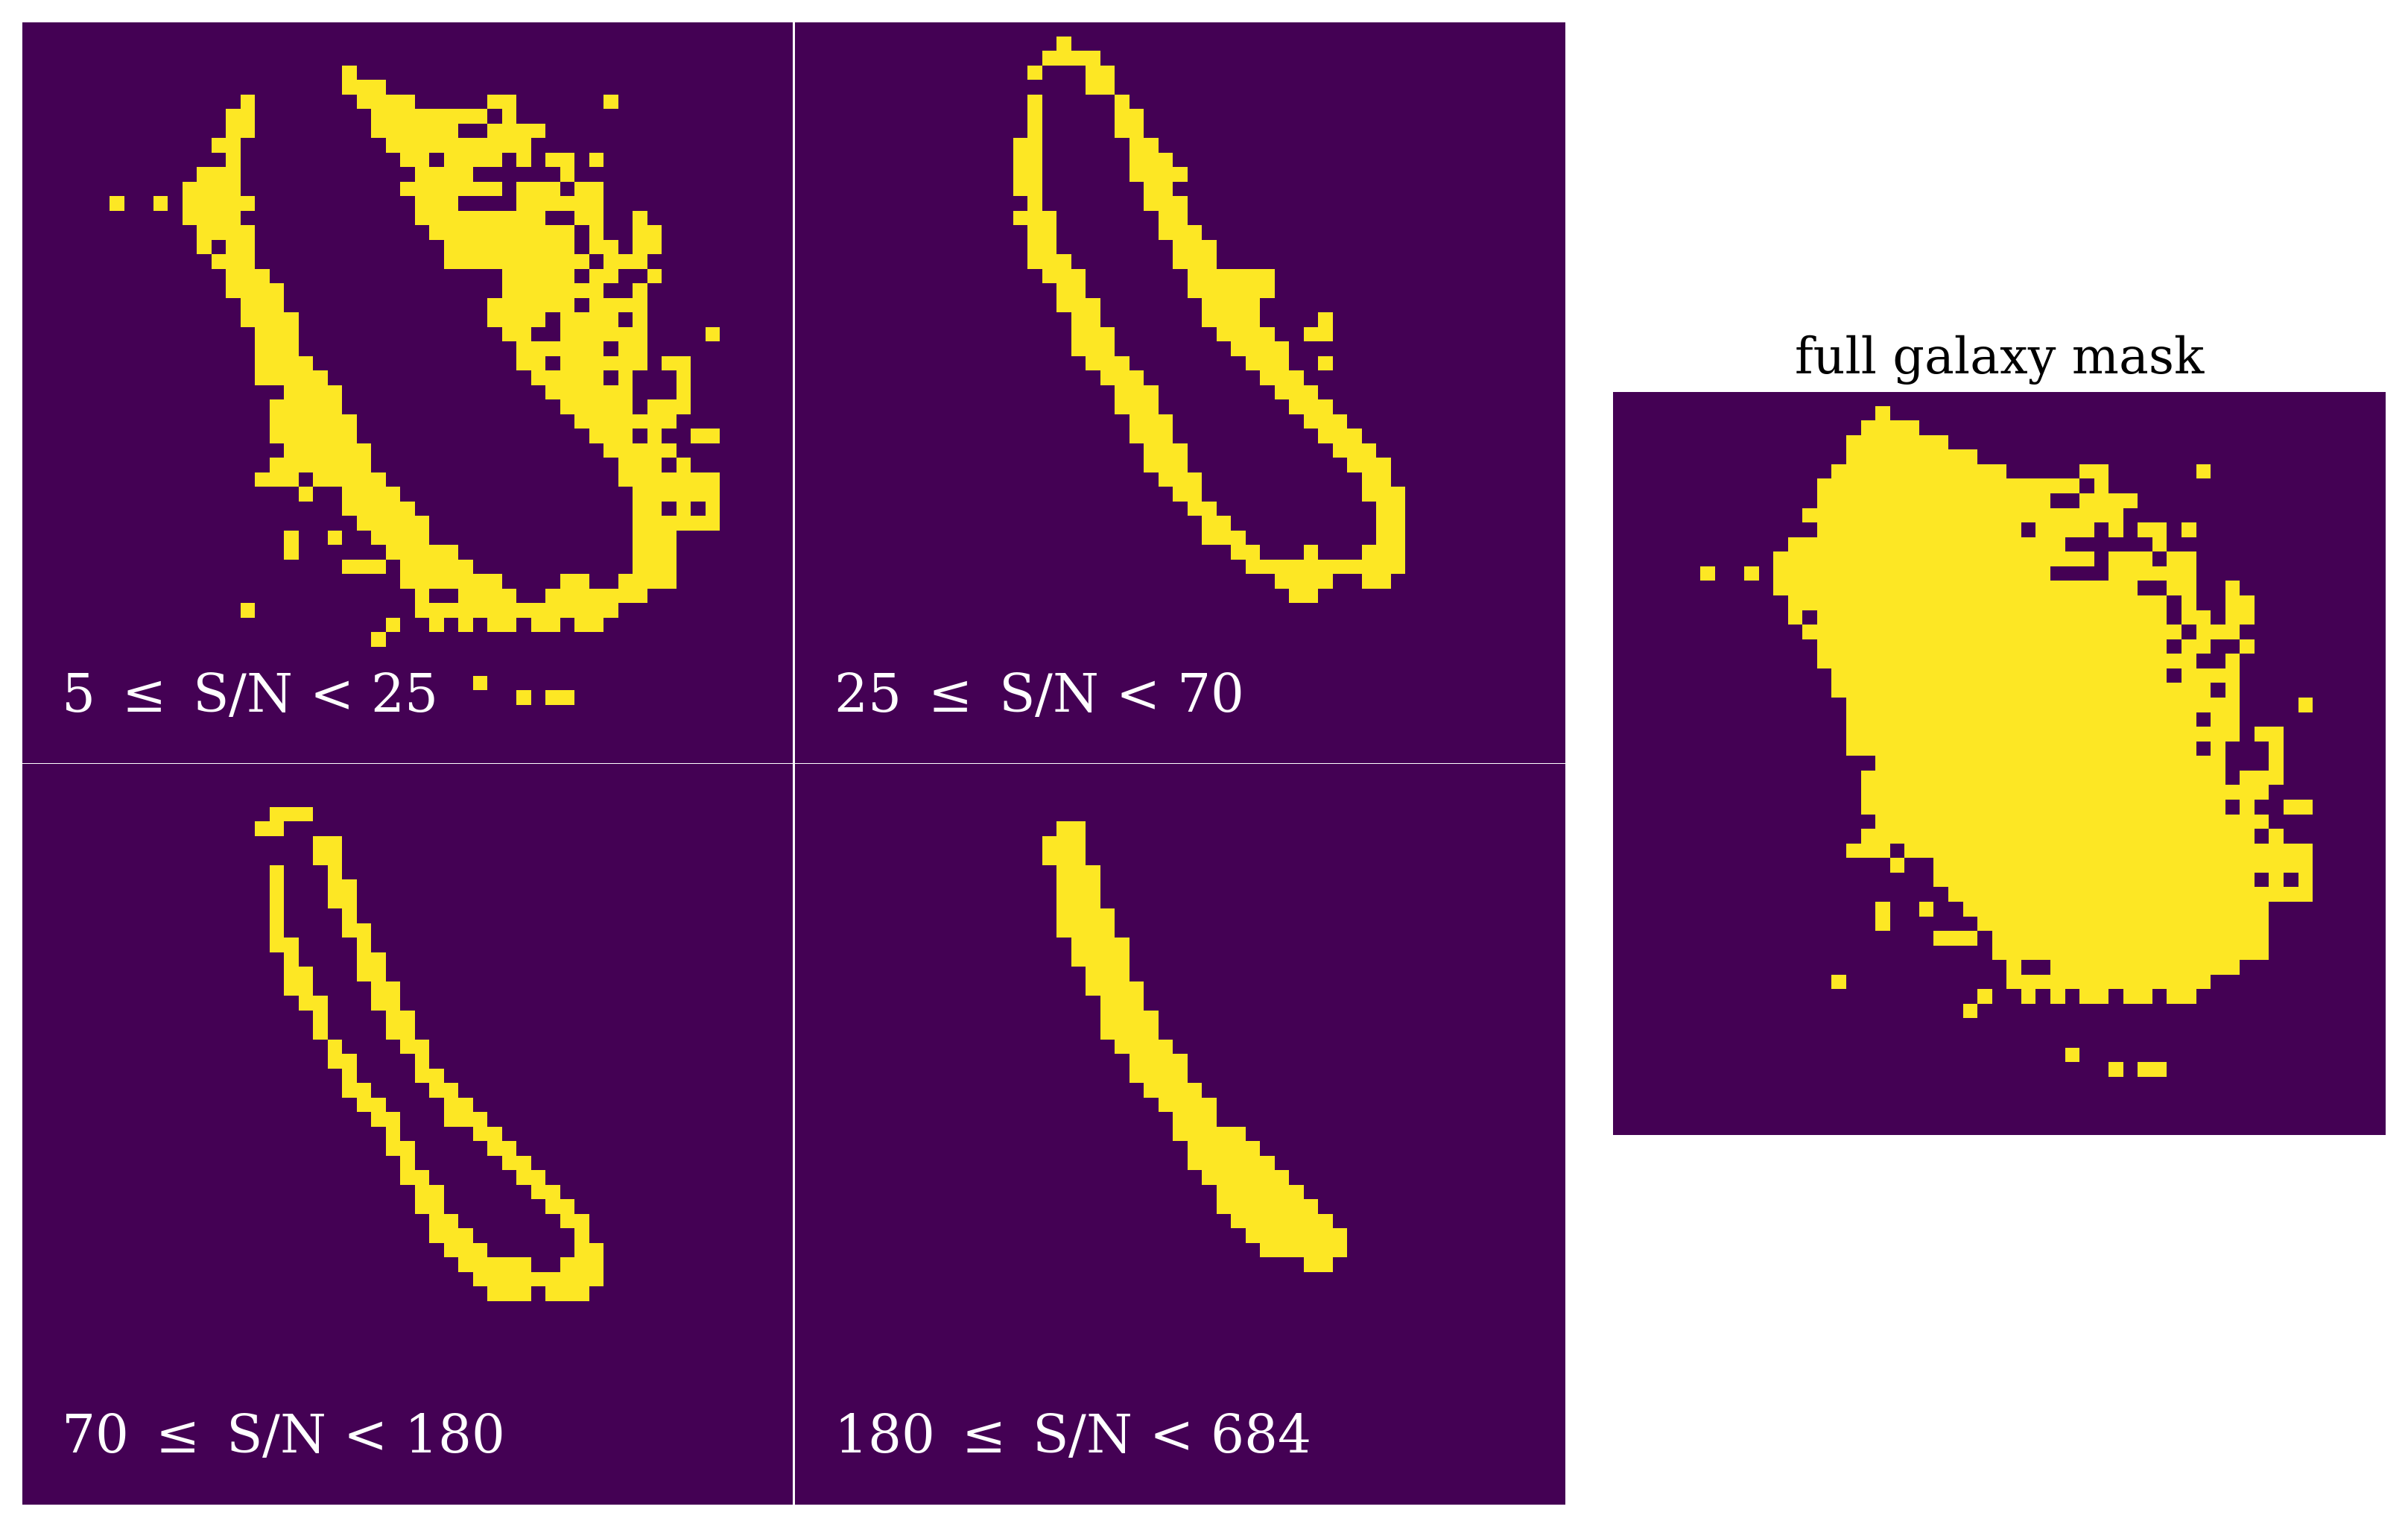

In [17]:
# LOOKING AT FINAL MAP WITH LAYERS
# --------------------------------
plt.figure(figsize=(11,7.05))
gs0 = gridspec.GridSpec(1,2,width_ratios=[2,1])


# PLOT 1:  the full galaxy mask
ax = plt.subplot(gs0[1])
ax.axis('off')

ax.imshow(new_map,origin='lower',cmap='viridis')
ax.set_title('full galaxy mask',fontsize=16)

ax.set_yticklabels([])
ax.set_xticklabels([])



# LOOKING AT MASK LAYERS
gs = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=gs0[0],
                    width_ratios=[1,1],height_ratios=[1,1],
                    wspace=0,hspace=0)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
axes = [ax1,ax2,ax3,ax4]
    

count = 0
for ax in axes:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.axis('off')

    layer = map_layers[count].copy()
    
    ax.imshow(layer,origin='lower',cmap='viridis')
    ax.text(0.05,0.07,f'{levels[count]} $\leq$ S/N < {levels[count+1]}',
         transform=ax.transAxes,fontsize=17,color='w')

    count += 1


plt.tight_layout()
plt.show()
plt.close('all')

-----------

## Final notes on masking

You may have noticed that for this example galaxy in the S/N layers plots (both the cell above and the previous cell) that in the second S/N bin ($25 \leq S/N < 70$) there were some lines of pixels on the top right that seemed higher S/N than the ones around them.  Those likely have artifacts or some other kind of noise in them artificially inflating the S/N in those spaxels so they appear in that bin instead of the lowest one ($5 \leq S/N < 25$) like their neighbors.  You can check this in DS9, clicking through those slices to look for hot pixels.

There are a few ways you can address this.  You could identify those pixels and reassign them to the lowest S/N bin, or you could use the pixel patch system we used before to bulk reassign pixels in that region to the lowest S/N bin (as most of those pixels already live in that bin).

I'll leave that fine-tuning up to you -- just wanted to point that out as additional steps that can (and should) be considered when making your galaxy masks.

<div class="alert alert-success">
    <b>NOTE</b> -- when making my galaxy masks (and S/N mask layers), I employ fine-tuning like described above to account for the leftover artifacts or noise in the straight-from-pipeline cubes.  This is important because your masks will be used in the layered sigma clipping routine, so you don't want to accidentally give a bad pixel more weight in the process (and therefore likely helping it avoid being clipped like it should).
</div>

------------

## Saving new mask to FITS file

In [ ]:
# pulling out the WCS info from cube
wcs_cube = WCS(header)
wcs_mask = wcs_cube.dropaxis(-1)
hdr_mask = wcs_mask.to_header()

In [19]:
hdu_list = []
hdu = fits.PrimaryHDU(new_map,header=hdr_mask) # full galaxy mask

for i in range(len(map_layers)):
    hdu_list.append(fits.ImageHDU(map_layers[i])) # adding each S/N mask layer

hdul = fits.HDUList([hdu,*hdu_list]) # final file
hdul.writeto(f'{target}-mask-layers.fits',overwrite=True) # saving FITS file


# SEPARATELY, saving layers info to txt file
np.savetxt(f'{target}-mask-layers-info.txt', map_layers_ranges, delimiter='\t',fmt='%.0f')

.  
.  
.  

### Congrats, you're done with making the full mask and the mask layers!

Now, on to the next notebook to run the **layered sigma clipping routine.**